# EDA
1) train <br>
2) merchant <br>
3) trans <br>
4) new_mct_trans

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn') # seaborn style
sns.set(font_scale=1)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # 명령문 결과 다 보여주기

#------------------------
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [2]:
import os
print(os.listdir("../input"))

['merchants.csv', 'Data_Dictionary.xlsx', 'historical_transactions.csv', 'new_merchant_transactions.csv', 'sample_submission.csv', 'test.csv', 'train.csv']


In [3]:
%%time
train = pd.read_csv('../input/train.csv', parse_dates=["first_active_month"])

CPU times: user 7.51 s, sys: 1.31 s, total: 8.82 s
Wall time: 8.86 s


## 1. train
0) card_id <br>
1) first_active_month <br>
2) target (+ y)<br>
3) feature_1 <br>
4) feature_2 <br>
5) feature_3 <br>

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 9.2+ MB


결측치 없음

In [6]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


### 0) card_id

In [7]:
train['card_id'].nunique()

201917

### 1) first_active_month

<Figure size 1008x432 with 0 Axes>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74]), <a list of 75 Text xticklabel objects>)

Text(0.5, 1.0, 'First active month count in train set')

Text(0.5, 0, 'First active month')

Text(0, 0.5, 'Number of CARDs')

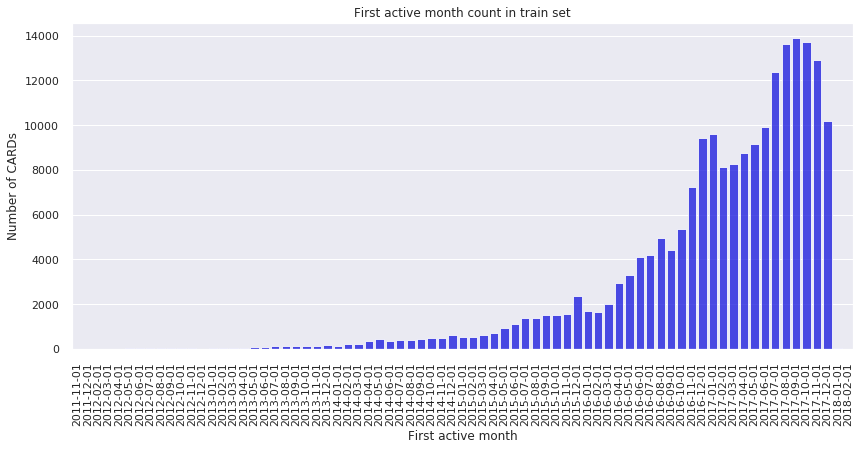

In [8]:
cnt_fam = train['first_active_month'].dt.date.value_counts()
cnt_fam = cnt_fam.sort_index()

plt.figure(figsize = (14,6))
sns.barplot(cnt_fam.index, cnt_fam.values, alpha = 0.8, color = 'blue')
plt.xticks(rotation = 90)
plt.title('First active month count in train set')
plt.xlabel('First active month')
plt.ylabel('Number of CARDs')

In [9]:
# plotly 이용
d1 = train['first_active_month'].value_counts().sort_index() # 필요한 데이터 
data = [go.Scatter(x=d1.index, y=d1.values, name='train')]   # plotly가 사용할 수 있는 data 형태
layout = go.Layout(dict(title = "Counts of first active",    # customizing
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Count')))
py.iplot(dict(data=data, layout=layout))

(plotly 그래프가 보기 좋음) <br>
first_active_month는 2011-11부터 2018-02까지 걸쳐 분포한다. 

In [10]:
# 누적 분포 그래프
d2 = train['first_active_month'].value_counts().sort_index().cumsum() # 필요한 데이터 
data = [go.Scatter(x=d1.index, y=d2.values, name='train')]   # plotly가 사용할 수 있는 data 형태
layout = go.Layout(dict(title = "Cumulative Counts of first active",    # customizing
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Cumulative Count')))
py.iplot(dict(data=data, layout=layout))

2016 ~ 2017년에 first_active인 카드가 많다. <br>
그래프의 기울기를 보면 각 시점에서 first active인 카드가 어느 정도로 증가하고 있는지 알 수 있다.

### 2) target(y-value)

In [11]:
train.target.describe()

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

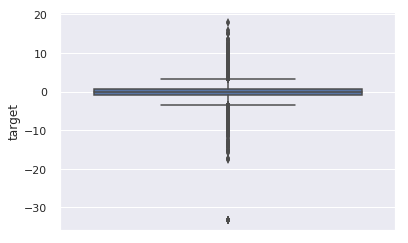

In [12]:
sns.boxplot(data=train, y='target')

거의 대부분이 0 근처에 몰려있다.~~이를 통해 두 가지 가설을 세울 수 있다. <br>
첫째, target(충성도)이 매우 섬세한 변수라서 0.XX의 작은 값도 생각보다 큰 값을 의미하거나, <br>
둘째, 대부분의 고객이 그닥 충성도가 높지 않은 상황이거나. <br>
어느 정도가 되야 충성도가 높은 것이고 어느 정도가 낮은 것인지 모르겠어서 좀 더 살펴봐야 할 것 같다. <br>~~
<br>
한 가지 눈에 띄는 것은 -30보다 작은 충성도가 outlier처럼 존재한다는 것이다. -30보다 작은 값을 살펴보자.

In [13]:
train[train['target'] < -30].target.value_counts()

-33.219281    2207
Name: target, dtype: int64

~~target이 -30보다 작은 경우는 2207개로 전체데이터 201917의 약 1%에 해당한다. <br> 
그리고 그 값은 모두 -33.219281로 같다. <br>
2207개의 값이 소수점까지 일치하는 사실은 정말정말 이상한데, 필립은 target을 예측하기 힘들만큼 독립변수가 주어지지 않은 경우에 '충성도 알 수 없음'을 대체한 값이라고 주장한다.
그에 대한 자세한 내용은 https://github.com/ka-to-top/Kaggle_Elo/blob/master/Code/%5BKaggle_Elo%5DEDA%20for%20Train(Philip).ipynb 에 있다.<br>
<br>
그렇다면 -33.219281을 제외한 나머지 target(99%)의 분포를 살펴보자.~~

-33.219281이라는 숫자가 똑같이 일치하는 것이 이상하다. 이를 통해 target이라는 변수는 실제 loyalty가 아니고, loyalty에 어떤 처리를 한 값이라고 생각할 수 있다. <br>
만약 $target=loyalty+(-33.219281)$로 만들어졌다면 loyalty=0일 때 -33.219281이 결과로 나타날 수 있다. <br>
<br>
다른 커널을 참고해서 target이 loyalty에 어떤 변환을 해준 것인지 알아낼 수 있었다. <br>
https://www.kaggle.com/raddar/towards-de-annymizing-the-data-some-insights <br>
$target=log_2(loyalty+0.0000000001)$ 이고 loyalty=0이면 $target=log_2(0.0000000001)=-33.2192809...$이 된다. <br>
따라서, 우리는 $y=2**target$인 y를 새로 정의해서 y를 종속변수로 바꿔서 예측할 수도 있다. <br>
`target`과 `y`중 종속변수로 더 적합한 것은 무엇일까? <br> 
`y`의 분포부터 살펴보자.

In [14]:
# <target 전체 분포 vs. -30보다 작은 target 제거한 경우의 분포> 비교
# * 참고) kurtosis는 뾰족한 정도가 아니라 outlier가 있는지 없는지 판단하는 기준으로 사용한다.

#train_df = train[train['target'] > -30]

#fig, axes = plt.subplots(2, 1, figsize=(14,10))
#sns.kdeplot(data=train['target'], shade=True, ax=axes[0]).set_title('All targets')
#sns.kdeplot(data=train_df['target'], shade=True, ax=axes[1]).set_title('Removed less than -30')
#plt.xlabel('targets')
#print('The kurtosis of first graph(All targets) is {}'.format(train['target'].kurtosis()))
#print('The kuttosis of second train(Removed less than -30) is {}'.format(train_df['target'].kurtosis()))

In [15]:
train['y'] = 2**train['target']

In [16]:
train['y'].describe()

count    2.019170e+05
mean     6.820184e+00
std      7.775483e+02
min      1.000000e-10
25%      5.421973e-01
50%      9.838860e-01
75%      1.699904e+00
max      2.558730e+05
Name: y, dtype: float64

In [17]:
x = train[train['y'] != train['y'].min()]['y'].min() # 0.000005
np.log2(x)
np.log2(0+0.0000000001)

-17.60814651

-33.219280948873624

Text(0.5, 1.0, 'Distribution of y(before processing)')

Text(0.5, 1.0, 'Boxplot of y(before processing)')

(0, 10)

(0, 5)

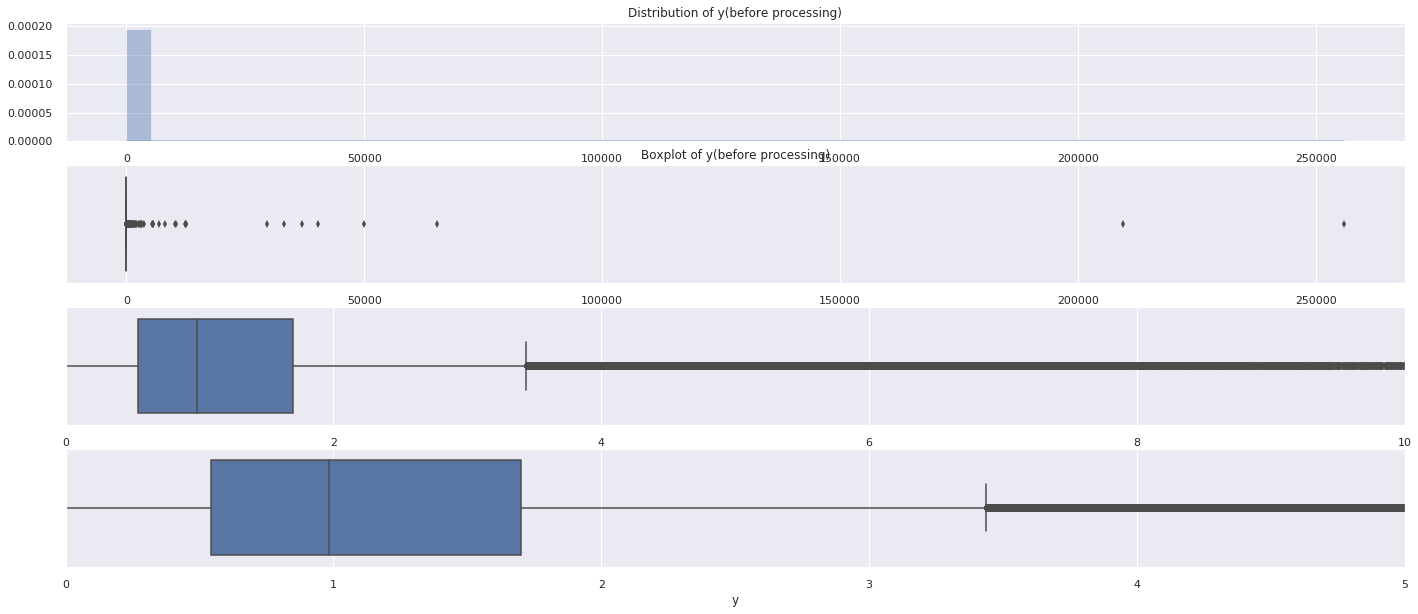

In [18]:
fig, axes = plt.subplots(4, 1, figsize=(24,10))
sns.distplot(train['y'], ax=axes[0]).set_title('Distribution of y(before processing)')
sns.boxplot(x=train['y'], ax=axes[1]).set_title('Boxplot of y(before processing)')
sns.boxplot(x=train['y'], ax=axes[2]).set_xlim(0,10)
sns.boxplot(x=train['y'], ax=axes[3]).set_xlim(0,5)

`y`는 `target`에 비해 직관적으로 받아들여져서 해석하기 좋다. <br>
그러나 `target`이 0주변에 몰렸던 것 처럼 `y`도 1주변에 값이 몰려있고, 분산이 너무 커진다는 단점이 있다. <br>
`target`과 `y` 중에 더 적합한 종속변수는 무엇일지 더 생각해보자.

~~**train data 변경**~~

~~이제 train은 train대신 outlier target이 제거된 train_df를 사용하겠다.~~

### 3,4,5) feature1/2/3

In [19]:
train.feature_1.value_counts()
train.feature_2.value_counts()
train.feature_3.value_counts()

3    73573
2    55797
5    40625
4    19885
1    12037
Name: feature_1, dtype: int64

1    89242
2    74839
3    37836
Name: feature_2, dtype: int64

1    114198
0     87719
Name: feature_3, dtype: int64

각 feature가 나타내는 값의 경우의 수는 5, 3, 2가지이다. 현재 data type은 `int64`이므로 범주형 변수로 바꾸자.

In [20]:
train['feature_1'] = train['feature_1'].astype('category')
train['feature_2'] = train['feature_2'].astype('category')
train['feature_3'] = train['feature_3'].astype('category')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 7 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null category
feature_2             201917 non-null category
feature_3             201917 non-null category
target                201917 non-null float64
y                     201917 non-null float64
dtypes: category(3), datetime64[ns](1), float64(2), object(1)
memory usage: 6.7+ MB


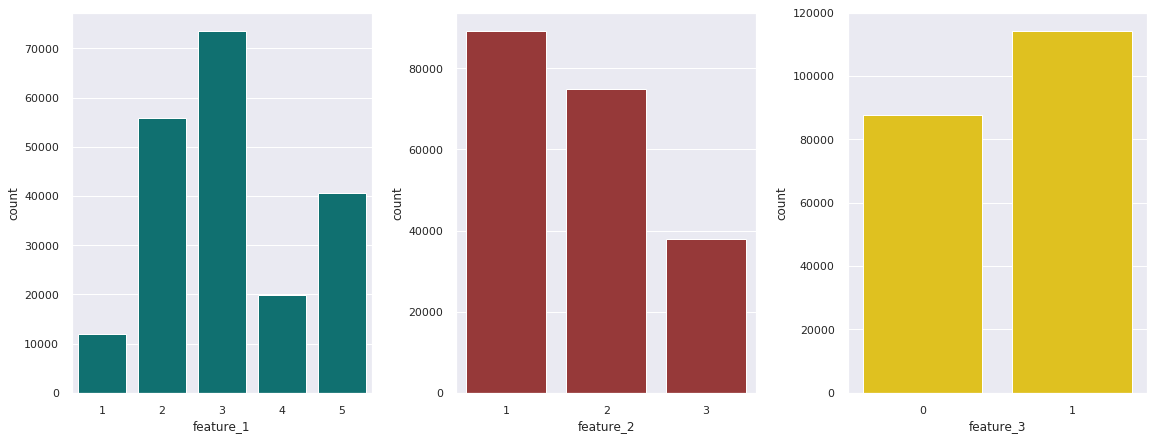

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(16,6), constrained_layout=True)
sns.countplot(data=train, x='feature_1', ax=axes[0], color='teal')
sns.countplot(data=train, x='feature_2', ax=axes[1], color='brown')
sns.countplot(data=train, x='feature_3', ax=axes[2], color='gold')

Text(0.5, 0.98, 'Violineplots for features and target')

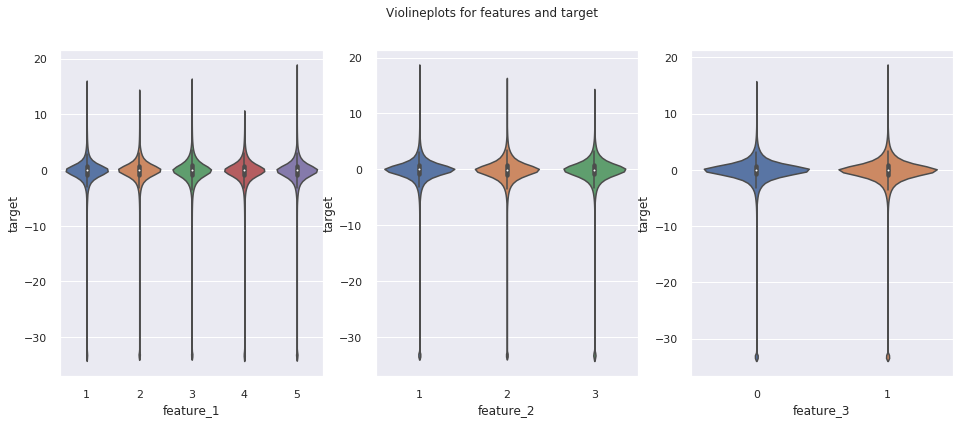

In [22]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6))
plt.suptitle('Violineplots for features and target');
sns.violinplot(x="feature_1", y="target", data=train, ax=ax[0], title='feature_1')
sns.violinplot(x="feature_2", y="target", data=train, ax=ax[1], title='feature_2')
sns.violinplot(x="feature_3", y="target", data=train, ax=ax[2], title='feature_3')

그래프를 보면 feature_1/2/3은 target에 거의 영향을 주지 않는다고 볼 수 있다. 

In [23]:
train.groupby('feature_1')['target'].describe()
train.groupby('feature_2')['target'].describe()
train.groupby('feature_3')['target'].describe()

,count,mean,std,min,25%,50%,75%,max
feature_1,,,,,,,,
1,12037.0,-0.315476,3.407106,-33.219281,-0.810411,-0.011003,0.666923,15.011358
2,55797.0,-0.350452,3.756032,-33.219281,-0.806444,0.000000,0.768908,13.592223
3,73573.0,-0.377533,3.834499,-33.219281,-0.956521,-0.036539,0.837927,15.606405
4,19885.0,-0.404652,3.817954,-33.219281,-0.856211,0.000000,0.728345,9.665204
5,40625.0,-0.499879,4.134833,-33.219281,-0.895946,-0.056208,0.692869,17.965068


,count,mean,std,min,25%,50%,75%,max
feature_2,,,,,,,,
1,89242.0,-0.398675,3.890548,-33.219281,-0.822850,-0.002394,0.738072,17.965068
2,74839.0,-0.332899,3.567683,-33.219281,-0.946076,-0.045086,0.799371,15.606405
3,37836.0,-0.501889,4.269270,-33.219281,-0.902546,-0.033784,0.766570,13.350895


,count,mean,std,min,25%,50%,75%,max
feature_3,,,,,,,,
0,87719.0,-0.357939,3.724459,-33.219281,-0.817775,0.000000,0.745114,15.011358
1,114198.0,-0.421057,3.944379,-33.219281,-0.934403,-0.044637,0.783653,17.965068


만약 `target`이 매우 민감한 변수라면 `feature_1/2/3`은 `target`에 영향을 줄 수도 있다.<br>
`feature_1/2/3`에 따른 `y`의 변화도 살펴보자.

Text(0.5, 0.98, 'Violineplots for features and target')

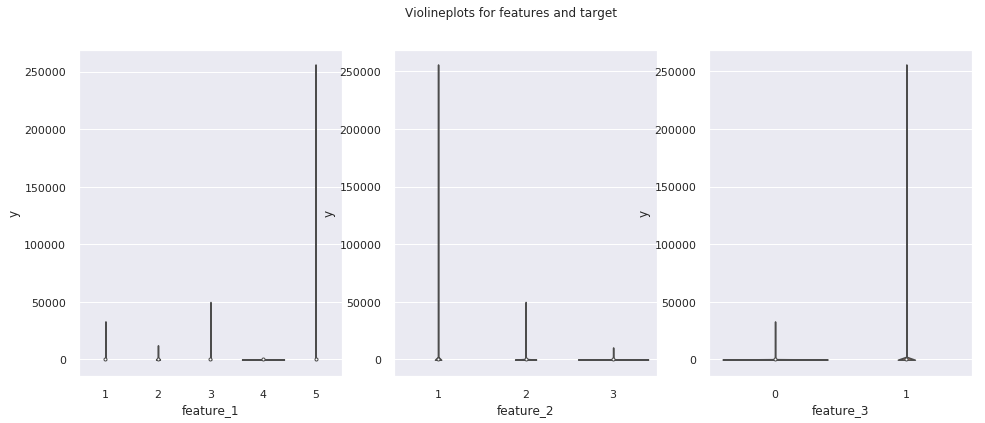

In [82]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6))
plt.suptitle('Violineplots for features and target');
sns.violinplot(x="feature_1", y="y", data=train, ax=ax[0], title='feature_1')
sns.violinplot(x="feature_2", y="y", data=train, ax=ax[1], title='feature_2')
sns.violinplot(x="feature_3", y="y", data=train, ax=ax[2], title='feature_3')

작은 값에 몰려있고 간혹 큰 값들이 존재해서 그래프로 `y`의 차이를 알아보기는 어렵다.

In [24]:
train.groupby('feature_1')['y'].describe()
train.groupby('feature_2')['y'].describe()
train.groupby('feature_3')['y'].describe()

,count,mean,std,min,25%,50%,75%,max
feature_1,,,,,,,,
1,12037.0,6.961818,324.138827,1.000000e-10,0.570219,0.992403,1.587683,33027.000040
2,55797.0,2.817052,73.602950,1.000000e-10,0.571790,1.000000,1.703980,12349.999988
3,73573.0,5.078793,262.740642,1.000000e-10,0.515298,0.974991,1.787479,49887.999907
4,19885.0,2.487709,13.683864,1.000000e-10,0.552401,1.000000,1.656738,811.925998
5,40625.0,17.550731,1685.572264,1.000000e-10,0.537395,0.961789,1.616495,255873.000873


,count,mean,std,min,25%,50%,75%,max
feature_2,,,,,,,,
1,89242.0,9.437562,1135.896944,1.000000e-10,0.565324,0.998342,1.667945,255873.000873
2,74839.0,5.607792,301.080238,1.000000e-10,0.519042,0.969232,1.740343,49887.999907
3,37836.0,3.044788,61.929206,1.000000e-10,0.534942,0.976855,1.701220,10447.679970


,count,mean,std,min,25%,50%,75%,max
feature_3,,,,,,,,
0,87719.0,3.311147,133.816511,1.000000e-10,0.567316,1.000000,1.676107,33027.000040
1,114198.0,9.515583,1027.234828,1.000000e-10,0.523259,0.969534,1.721484,255873.000873


만약 `y`가 매우 민감한 변수라면 `feature_1/2/3`가 `y`에 영향을 줄 수 있다.

#### ◀ 정리 ▶

* 결측치 없음
* `first_active_month` : 2011-11 ~ 2018-02
* `target`, `y`는 얼마나 섬세하게 움직이는 변수일까? <br>
* ~~`target`에서 -33.219281인 데이터 제거 → **train_df** 사용~~
* `target`을 쓸까? `y`를 쓸까?

